In [1]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import numpy as np


In [2]:
# === MOUNT GOOGLE DRIVE ===
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Define Paths & Hyperparameters
# Path to JAFFE dataset stored in Google Drive or locally
DATASET_PATH = "/content/drive/My Drive/jaffe"

# Image settings
IMG_SIZE = (150, 150)  # Resize all images to 150x150
BATCH_SIZE = 32        # Number of images per batch
EPOCHS = 2            # Number of training epochs


In [4]:
# Define ImageDataGenerator with a 30% split for validation+test
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.30)

# Training Set (70% of total dataset)
train_generator = data_gen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation & Test Split (Each 15%)
val_test_generator = ImageDataGenerator(rescale=1./255, validation_split=0.50)

# Validation Set (15% of total dataset)
val_generator = val_test_generator.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # 50% of validation+test -> becomes 15% of total
)

# Test Set (15% of total dataset)
test_generator = val_test_generator.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # 50% of validation+test -> becomes 15% of total
)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:146: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn(


Found 151 images belonging to 7 classes.
Found 108 images belonging to 7 classes.
Found 105 images belonging to 7 classes.


In [5]:
model = Sequential()

# Input Layer with Normalization
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)))

# First Convolutional Layer
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent Overfitting
model.add(Dense(train_generator.num_classes, activation='softmax'))  # Output Layer


# Compile the model with categorical_crossentropy
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Correct loss function
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,402,695 (20.61 MB)

 Trainable params: 5,402,695 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
EPOCHS = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,  # Use validation generator
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.0729 - loss: 1.9480 - val_accuracy: 0.1481 - val_loss: 1.9456
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0949 - loss: 1.9497 - val_accuracy: 0.1481 - val_loss: 1.9459
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1447 - loss: 1.9453 - val_accuracy: 0.1481 - val_loss: 1.9458
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1785 - loss: 1.9455 - val_accuracy: 0.1481 - val_loss: 1.9458
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.1495 - loss: 1.9462 - val_accuracy: 0.1481 - val_loss: 1.9458


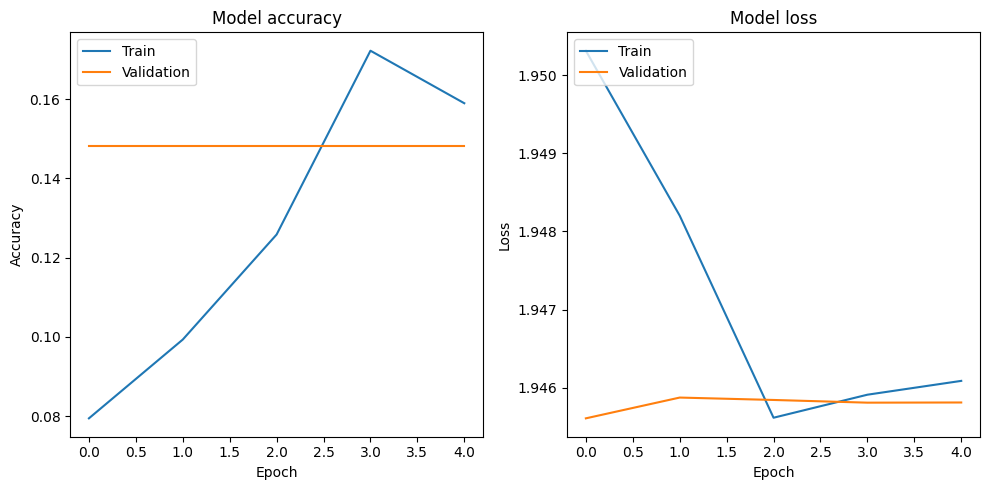

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))  # Adjust figure size if needed

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1495 - loss: 1.9455
Test Accuracy: 15.24%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted class: FEA
Prediction probabilities: [0.14143354 0.14288352 0.14406978 0.14317147 0.14208767 0.14312978
 0.14322425]


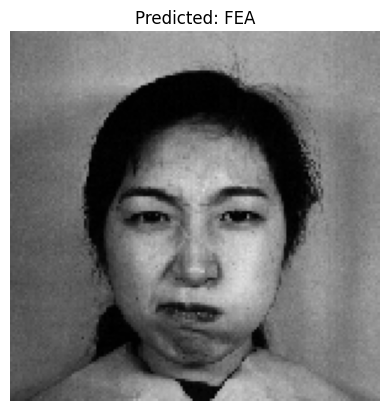

In [11]:
# prompt: get a test image and show the test result of the model

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the path to your test image
test_image_path = "/content/drive/My Drive/jaffe/ANG/KA.AN1.39.tiff" # Replace with the actual path


img = image.load_img(test_image_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize the image


predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])

# Assuming class_indices is available from your training generator
class_labels = list(train_generator.class_indices.keys())

predicted_class = class_labels[predicted_class_index]


print(f"Predicted class: {predicted_class}")
print(f"Prediction probabilities: {predictions[0]}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()
